mv: cannot stat 'kaggle.json': No such file or directory
... resuming from 1515192320 bytes (6270765576 bytes left) ...
100% 7.25G/7.25G [00:55<00:00, 166MB/s]
100% 7.25G/7.25G [00:55<00:00, 112MB/s]
(4000, 2)


100%|██████████| 4000/4000 [01:00<00:00, 66.49it/s]


(4000, 224, 224, 3)
(4000, 5)
Original y_train: [2960  268  601   92   79]
Multilabel version: [4000 1040  772  171   79]
29084464/29084464 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 7042629 (26.87 MB)
Trainable params: 6958981 (26.55 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


<ipython-input-3-59884c824a24>:271: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


107/106 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.9779

TypeError: 'NoneType' object is not subscriptable

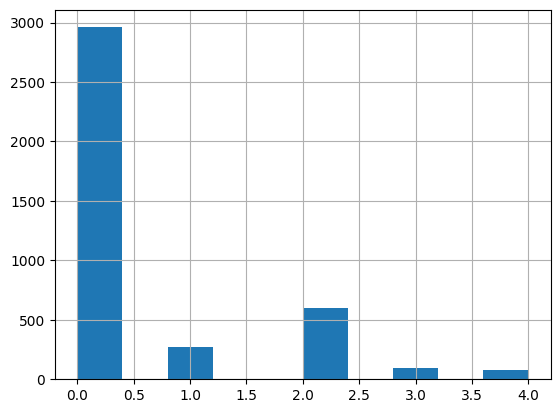

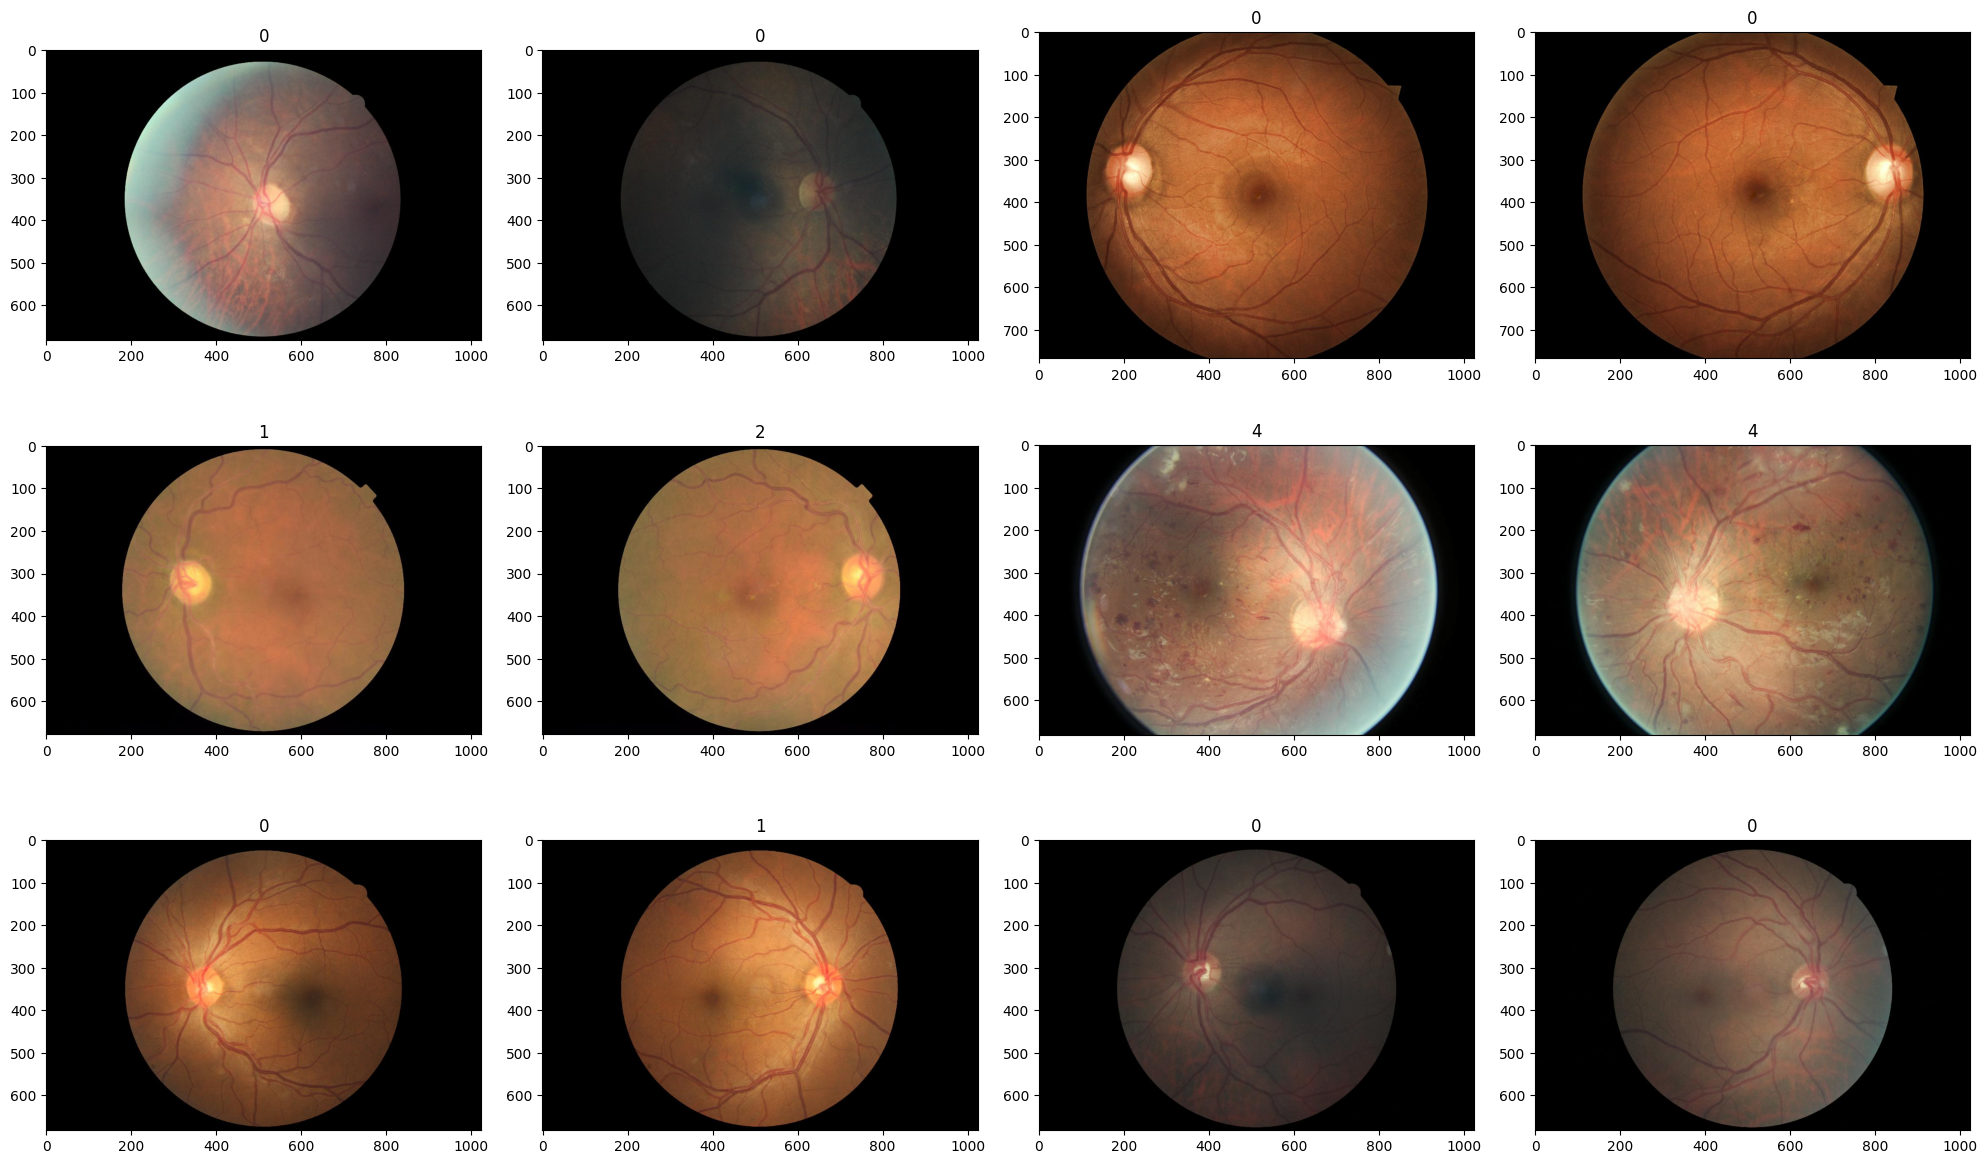

In [3]:
# Install Kaggle package
!pip install kaggle

# Import necessary libraries
import os
from google.colab import files

# Move Kaggle API key to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

# Unzip the dataset
import zipfile
with zipfile.ZipFile("diabetic-retinopathy-resized.zip", 'r') as zip_ref:
    zip_ref.extractall("diabetic-retinopathy-resized")

# Import necessary libraries
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(2015)
tf.random.set_seed(2015)

# Load the training data
train_df = pd.read_csv('/content/diabetic-retinopathy-resized/trainLabels.csv')
train_df = train_df.head(4000)  # Limit to 4000 samples for demonstration
print(train_df.shape)
train_df.head()

# Visualize distribution of classes
train_df['level'].hist()
train_df['level'].value_counts()

# Function to display samples
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'image']
        image_id = df.loc[i,'level']
        img = cv2.imread(f'/content/diabetic-retinopathy-resized/resized_train/resized_train/{image_path}.jpeg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_df)

# Function to pad images to desired size
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

# Function to preprocess images
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)

    return im

# Preprocess images and create training data
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['image'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/content/diabetic-retinopathy-resized/resized_train/resized_train/{image_id}.jpeg'
    )

y_train = pd.get_dummies(train_df['level']).values

print(x_train.shape)
print(y_train.shape)

# Create multilabel version of y_train
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi,
    test_size=0.15,
    random_state=2015
)

# Define a MixupGenerator class
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

# Set batch size
BATCH_SIZE = 32

# Function to create ImageDataGenerator
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        fill_mode='constant',  # set mode for filling points outside the input boundaries
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True,  # randomly flip images vertically
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

# Calculate accuracy score
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

accuracy_score(true_labels, pred_labels)

# Calculate Cohen's kappa score
cohen_kappa_score(true_labels, pred_labels)

# Define Metrics callback class
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Load DenseNet121 model
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Function to build the model
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )

    return model

# Build the model
model = build_model()
model.summary()

# Initialize Metrics callback
kappa_metrics = Metrics()

# Train the model
history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=1,  # For demonstration, set to 1 epoch. Increase as needed.
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)
